In [1]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api as hp

## Downloading and preprocessing the data

In [2]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
# Downloading the MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [5]:
# Creating a function to scale our data
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [6]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [7]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [8]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [9]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [10]:
# Splitting the dataset into trainig + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [11]:
# Batching the data
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = mnist_test.map(scale).batch(num_test_samples)

## Defining hyperparameters

In [12]:
# Defining the hypermatarest we would test and their range
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([3,5,7]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

# Logging setup info
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

## Cerating functions for training our model and for logging purposes

In [13]:
# Wrapping our model and training in a function
def train_test_model(hparams):
    
    # Outlining the model/architecture of our CNN
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    
    # Defining the loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compiling the model with parameter value for the optimizer
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss=loss_fn, metrics=['accuracy'])
    
    # Defining early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    
    # Training the model
    model.fit(
        train_data, 
        epochs = NUM_EPOCHS,
        callbacks = [early_stopping],
        validation_data = validation_data,
        verbose = 2
    )
    
    _, accuracy = model.evaluate(test_data)
    
    return accuracy

In [14]:
# Creating a function to log the resuls
def run(log_dir, hparams):
    
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

## Training the model with the different hyperparameters

In [15]:
# Performing a grid search on the hyperparameters we need to test
session_num = 0

for filter_size in HP_FILTER_SIZE.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
    
        hparams = {
            HP_FILTER_SIZE: filter_size,
            HP_OPTIMIZER: optimizer
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

--- Starting trial: run-0
{'filter_size': 3, 'optimizer': 'adam'}
Epoch 1/20
422/422 - 31s - loss: 0.2946 - accuracy: 0.9191 - val_loss: 0.0958 - val_accuracy: 0.9730 - 31s/epoch - 75ms/step
Epoch 2/20
422/422 - 27s - loss: 0.0813 - accuracy: 0.9754 - val_loss: 0.0538 - val_accuracy: 0.9842 - 27s/epoch - 65ms/step
Epoch 3/20
422/422 - 30s - loss: 0.0577 - accuracy: 0.9823 - val_loss: 0.0494 - val_accuracy: 0.9855 - 30s/epoch - 72ms/step
Epoch 4/20
422/422 - 29s - loss: 0.0483 - accuracy: 0.9856 - val_loss: 0.0520 - val_accuracy: 0.9857 - 29s/epoch - 69ms/step
Epoch 5/20
422/422 - 41s - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.0276 - val_accuracy: 0.9920 - 41s/epoch - 98ms/step
Epoch 6/20
422/422 - 41s - loss: 0.0364 - accuracy: 0.9889 - val_loss: 0.0303 - val_accuracy: 0.9905 - 41s/epoch - 98ms/step
Epoch 7/20
422/422 - 38s - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0268 - val_accuracy: 0.9918 - 38s/epoch - 91ms/step
Epoch 8/20
422/422 - 40s - loss: 0.0280 - accuracy: 0.9917 

422/422 - 27s - loss: 0.0265 - accuracy: 0.9918 - val_loss: 0.0185 - val_accuracy: 0.9940 - 27s/epoch - 63ms/step
Epoch 7/20
422/422 - 27s - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0177 - val_accuracy: 0.9942 - 27s/epoch - 64ms/step
Epoch 8/20
422/422 - 29s - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0148 - val_accuracy: 0.9958 - 29s/epoch - 69ms/step
Epoch 9/20
422/422 - 32s - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0185 - val_accuracy: 0.9952 - 32s/epoch - 76ms/step
Epoch 10/20
422/422 - 32s - loss: 0.0130 - accuracy: 0.9958 - val_loss: 0.0103 - val_accuracy: 0.9972 - 32s/epoch - 76ms/step
Epoch 11/20
422/422 - 29s - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0053 - val_accuracy: 0.9990 - 29s/epoch - 68ms/step
Epoch 12/20
422/422 - 29s - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0072 - val_accuracy: 0.9975 - 29s/epoch - 68ms/step
Epoch 13/20
422/422 - 28s - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.0071 - val_accuracy: 0.9980 - 28s/epoch - 67ms/step
1/1 [==

## Visualizing the hyperparameter results with Tensorboard

In [19]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


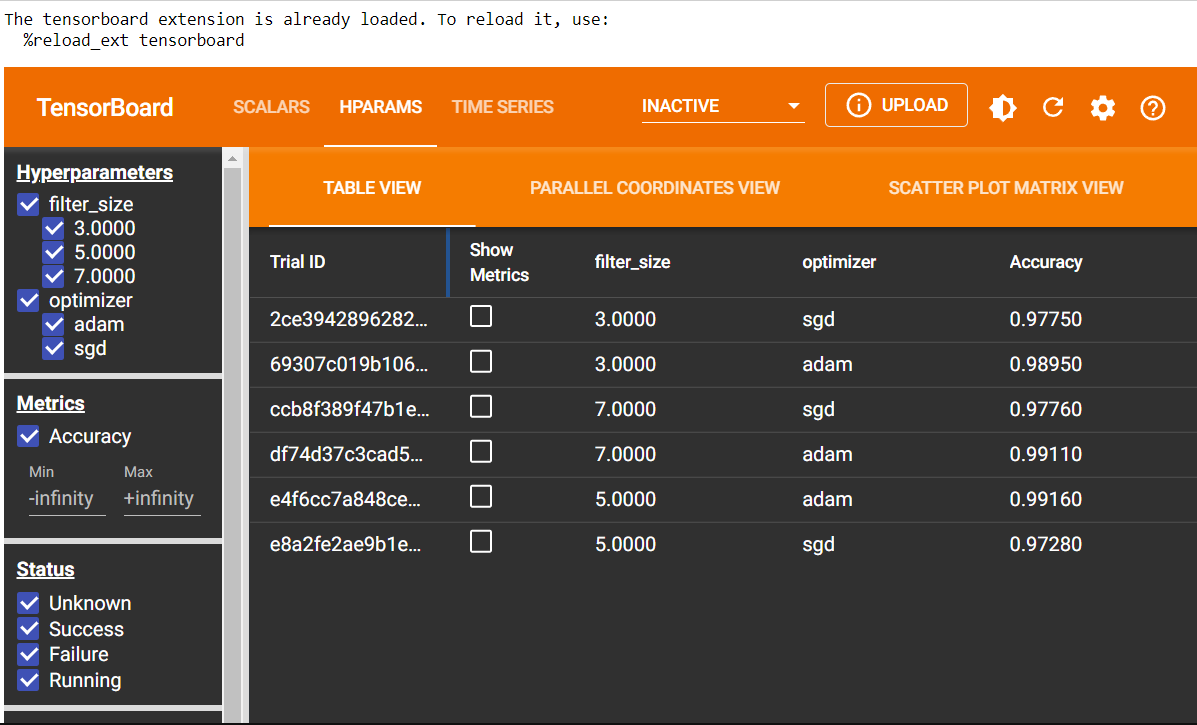